In [1]:
## In this notebook we will try to classify the images into different classes.
## We will use the approach followed in CIFAR-10 paper.
## First the network has a pre-processing layer which distorts the input images so as to artificially inflate the training-set. 
## Then the network has two convolutional layers, two fully-connected layers and finally a softmax classification layer.

In [2]:
##--------------------------------------------------------------------------------
## Summary : classify images into classes
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##--------------------------------------------------------------------------------

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import prettytensor as pt
import os
import download

from sklearn.metrics import confusion_matrix

In [3]:
## Lets declare some constants we will be using 
data_path = '/home/srvv/Documents/TensorFlow/DeepLearning/ImageRecognition/CIFAR10/'

img_size = 32
numChannels = 3
img_size_flat = img_size*img_size*numChannels
numClasses = 10
numExamples = 50000
numExamplesPerFile = 10000

clsNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
## Lets define a function to read read the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Lets define a function to normalize images
def normalize(rawImages):
    # we read images and normalize them by (value/255)
    # convert them to [-1,img_size,img_size,numChannels]
    raw = np.array(rawImages,dtype=float)/255.0
    images = raw.reshape([-1, numChannels, img_size, img_size])
    
    ##reorder images to get the right image
    images = images.transpose([0,2,3,1])
    return images

In [5]:
##lets list all files in the directory
files = os.listdir(data_path)
print(files)

dataFiles = [file for file in files if 'data_batch' in file]
print(dataFiles)

['test_batch', 'batches.meta', 'data_batch_4', 'readme.html', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_5']
['data_batch_4', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_5']


In [6]:
## Lets join data from all files into one big file

images = np.zeros(shape=[numExamples,img_size,img_size,numChannels],dtype=np.float32)
labels = np.zeros(shape=[numExamples],dtype=np.float32)

for i,file in enumerate(dataFiles):
    dict = unpickle(os.path.join(data_path,file))
    rawImages = dict[b'data']
    dataLabels = dict[b'labels']
    begin = i*numExamplesPerFile
    end = (i+1)*numExamplesPerFile
    images[begin:end,:] = normalize(rawImages)
    labels[begin:end] = dataLabels

print(np.shape(labels))
print(np.shape(images))

(50000,)
(50000, 32, 32, 3)


In [7]:
## Declaring function to plot images
def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #create a 3x3 subplot
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.6,wspace=0.6)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i],interpolation='spline16')
        
        if predLabels==None:
            xlabel = 'True : '+str(clsNames[int(trueLabels[i])])
        else : 
            xlabel = 'True : '+str(clsNames[int(trueLabels[i])])+' Pred : '+str(clsNames[int(predLabels[i])])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

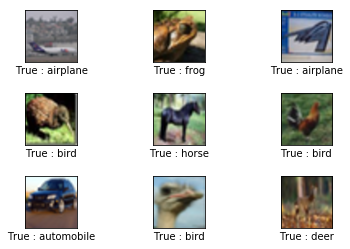

In [8]:
## lets plot some images
plotImages(images[0:9],labels[0:9])

In [9]:
##lets write a function to print weights
def printConfMatrix(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)

##Function to print wrong examples    
def printExampleErrors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    plotImages(incorrectImages[0:9],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [10]:
##lets write a function to plot conv weights
def plotConvWeights(weights,inputChannel=0):
    ##find max and min of weights
    w_max = np.max(weights)
    w_min = np.min(weights)
    
    ##lets get number of weights to plot
    numFilters = weights.shape[3]
    
    ##lets get number of images per axis
    numGrids = math.ceil(math.sqrt(numFilters))
    
    (fig,axes) = plt.subplots(numGrids,numGrids)
    fig.subplots_adjust(hspace=0.6,wspace=0.6)
    for i,ax in enumerate(axes.flat):
        ##Remove the axes where there are no filters
        if i<numFilters:
            image = weights[:,:,inputChannel,i]
            ax.imshow(image,vmax=w_max,vmin=w_min,interpolation='nearest', cmap='seismic')
            ax.set_xlabel('Filter : '+str(i))
        
            #remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

In [11]:
##lets write a function to plot conv weights
def plotConvWeights(weights,inputChannel=0):
    ##find max and min of weights
    w_max = np.max(weights)
    w_min = np.min(weights)
    
    ##lets get number of weights to plot
    numFilters = weights.shape[3]
    
    ##lets get number of images per axis
    numGrids = math.ceil(math.sqrt(numFilters))
    
    (fig,axes) = plt.subplots(numGrids,numGrids)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ##Remove the axes where there are no filters
        if i<numFilters:
            image = weights[:,:,inputChannel,i]
            ax.imshow(image,vmax=w_max,vmin=w_min,interpolation='nearest', cmap='seismic')
            ax.set_xlabel('Filter : '+str(i))
        
            #remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

In [12]:
##lets create the graph 

##Input PlaceHolders
x = tf.placeholder(tf.float32,shape=[None,img_size_flat])
y_true = tf.placeholder(tf.float32,shape=[None,numClasses])

## We are passing the image to cnn so need to resize it 
x_image = tf.reshape(x,[-1,img_size,img_size,1])

##Pretty Tensor
x_pretty = pt.wrap(images)

##Model declaration
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred,loss = x_pretty.conv2d(kernel=5,depth=10,name='layer1').max_pool(kernel=2,stride=2).\
            conv2d(kernel=5,depth=24,name='layer2').max_pool(kernel=2,stride=2).\
            flatten().fully_connected(size=256,name='layerfc').\
            flatten().fully_connected(size=64,name='layerfc').\
            softmax_classifier(num_classes=numClasses, labels=y_true)
    
            
## accuracy
correct = tf.equal(tf.argmax(y_pred,dimension=1),tf.argmax(y_true,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

##Optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [13]:
## Saver function to save best stopping. We are exploring early stopping here
saver = tf.train.Saver()
saveDir = 'savedState/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
savePath = os.path.join(saveDir, 'best_validation')    


In [14]:
##Lets write a function to get the weights from this pretty tensor

# Retrieve an existing variable named 'weights' in the scope
# with the given layer_name.
def getWeights(layerName):
    with tf.variable_scope(layerName,reuse=True):
        variable = tf.get_variable('weights')
        
    return variable

In [15]:
weights1 = getWeights('layer1')
weights2 = getWeights('layer2')

In [16]:
## lets start running the graph
session = tf.Session()
session.run(tf.global_variables_initializer())

def runOptimization(numIter):
    ## Initialize variables for accuracies.For early stopping we should stop at point
    ## where the testing accuracies don't improve.
    bestAccuracy = 0.0
    lastImprIter = 0
    maxIterWithOutImpr = 2
    curIteration = 0
    for i in range(0,numIter):
        curIteration = curIteration+1
        batchSize = 100
        startTime = time.time()
        numIterations = int(len(data.train.labels)/batchSize)
        
        for j in range(0,numIterations):
            x_batch = images[(i*batchSize):(i+1)*batchSize,:]
            y_batch = labels[(i*batchSize):(i+1)*batchSize]
            
            feed = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict=feed)
            
        labelsTrain = session.run(y_pred,feed_dict={x:data.train.images,y_true:data.train.labels})
        ##labelsTest = session.run(y_pred,feed_dict={x:data.test.images,y_true:data.test.labels})
        w1 = session.run(weights1,feed_dict={x:images,y_true:data.train.labels})
        w2 = session.run(weights2,feed_dict={x:data.train.images,y_true:data.train.labels})
        
        accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
        ##accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        #if accuracy improves at least 0.1%
        if((accuracyTrain-bestAccuracy)>=0.001):
            bestAccuracy = accuracyTrain
            lastImprIter = curIteration
            ##Save the state
            saver.save(sess=session,save_path=savePath)
            isImproved = '*'
        else:
            isImproved = ''
        
        print('Iteration ',str(i),':-  ','Training accuracy : ',accuracyTrain*100,str(isImproved))
        print('Time Taken : ',str(time.time()-startTime),'seconds')
        
        if(curIteration-lastImprIter>maxIterWithOutImpr):
            print('No improvements in testing accuracy for a while. Performing \'Early Stopping\'')
            break
            
    return labelsTrain,w1,w2

In [ ]:
labelsTrain,w1,w2 = runOptimization(2)